Clasificación básica de texto --- 39:49 min
===

* 39:49 min | Última modificación: Mayo 3, 2021 | [YouTube](https://youtu.be/WTA5hUTznxs)

Basado en:

* https://www.tensorflow.org/tutorials/keras/text_classification_with_hub

* https://www.tensorflow.org/tutorials/text/word_embeddings


TensorFlow tiene funcionalidades que facilitan la construcción de modelos predictivos a partir del procesamiento de texto. En esta lección se aborda el proceso de construcción de un clasificador que permite determinar si una crítica de una pelicula en IMDB es positiva o negativa usando TensorFlow. Este es un problema de análisis de sentimientos.  

In [1]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

2.4.1


## Descarga de datos

**Descarga de datos en Google Colab***

```python
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1",
    url,
    untar=True
    cache_dir=".",
    cache_subdir="",
)

```



**Descarga de datos en Terminal**

```bash
$ wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
$ tar -zxf aclImdb_v1.tar.gz
```

In [2]:
#
# Este es el valor devuelto por
# dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
#
dataset_dir = "./aclImdb"

#
# Contenido del directorio ./aclImdb
# Note que los mensajes ya estan divididos en conjuntos
# de entrenamiento y prueba
#
!ls -1 {dataset_dir}

README
imdb.vocab
imdbEr.txt
test
train


## Organización de los datos

In [3]:
#
# Contenido del directorio de entrenamiento
#
train_dir = dataset_dir +  "/train"
!ls -1 {train_dir} 

labeledBow.feat
neg
pos
unsupBow.feat
urls_neg.txt
urls_pos.txt
urls_unsup.txt


In [4]:
#
# Ejemplo de un mensaje positivo
#
!cat {train_dir + "/pos/1181_9.txt"}  

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.

In [5]:
#
# Remueve el directorio unsup
#
!rm -rf {train_dir + "/unsup"}

In [6]:
BATCH_SIZE = 32
SEED = 42

#
# La función text_dataset_from_directory permite leer los
# archivos de un directorio. Usa el 80% de los datos de train
# para entrenamiento y el 20% restante para validación.
# Note que la función debe llamarse dos veces.
#
# Cada mensaje es almacenado como un archivo individual y
# cada directorio representa una categoria (pos/neg)
#
# Quedan tres conjuntos de datos train, test y validation
#

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
)

#
# raw_train_ds es una tupla conformada por la lista de
# mensajes que conforman el batch y la lista de enteros 
# que codifican la clase.
#
#  (
#    [msg1, msg2, ...]
#    [lbl1, lbl2, ...]
#  )
#
# text_batch es una lista de strings (primer batch), donde
# cada string es una de las revisiones. 
#
# label batch es una lista de enteros {0,1} que corresponden
# a la categoría del mensaje.
#
# Imprime los primeros tres mensajes y su etiqueta
# del primer batch
#
print()
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print()
        print("Label", label_batch.numpy()[i])
        print()

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'

Label 0

Review b"David Mamet is a very interesting and a very un-equal director. His

In [7]:
#
# Categorias
#
for i, name in enumerate(raw_train_ds.class_names):
    print(i, name)

0 neg
1 pos


In [8]:
#
# Lee los mensajes del grupo de testing
#
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=BATCH_SIZE,
)

Found 25000 files belonging to 2 classes.


## Representación de texto usando Document-Term-Matrix

Considere la siguientes frases: "Hola mundo cruel", "El mundo es cruel".

Es ineficiente porque genera una matriz que tiene la mayor parte de sus términos iguales a cero.

            Hola  mundo  cruel    El   es
            
    msg 1      1      1      1     0    0  
    
    msg 2      0      1      1     1    1
 
 

## Codificación de cada palabra como un entero único

La codificación como enteros es arbitraria y no captura las relaciones entre palabras.

Es muy dificil interpretar el modelo resultante.

    Hola:  1
    mundo: 2
    cruel: 3
    El:    4
    es:    5
    
    
    msg1: [1, 2, 3]
    msg2: [4, 2, 5, 3]

In [9]:
tv = TextVectorization(
    max_tokens=7,             # tamaño del vocabulario (palabras + '' + [UKNOWN])
    output_mode="int",        # enteros
    output_sequence_length=4, # numero de palabras por frase
)

tv.adapt(
    ["Hola mundo cruel", "El mundo es cruel"]
)

tv.get_vocabulary()

['', '[UNK]', 'mundo', 'cruel', 'hola', 'es', 'el']

In [10]:
tv(["Hola mundo cruel", "El mundo es cruel"]).numpy()

array([[4, 2, 3, 0],
       [6, 2, 5, 3]])

## Representación de palabras usando Embedding

Cada palabra es representada por un vector de números reales de n dimensiones, en el que palabras similares tienen una representación similar, y los cuales pueden capturar relaciones entre palabras. Esta es una matriz de la forma

              dim_0  dim_1  dim_2
     word_0      .       .      . 
     word_1      .       .      .
     word_2      .       .      .
     ...         .       .      .

In [11]:
#
# El siguiente codigo crea una capa con un 
# vocabulario de 1000 palabras y 5 dimenciones
#
embedding_layer = layers.Embedding(1000, 5)

#
# Representación un vector de palabras (frase) 
# como un embeding
#
embedding_layer(tf.constant([0, 0, 1, 2, 3, 8])).numpy()

array([[ 0.01094563,  0.0473342 ,  0.00087859, -0.02028556, -0.04986701],
       [ 0.01094563,  0.0473342 ,  0.00087859, -0.02028556, -0.04986701],
       [-0.02175917,  0.03644494,  0.04551655,  0.0337589 ,  0.01326085],
       [-0.02706339,  0.0217892 ,  0.04538036, -0.00362183,  0.03315837],
       [-0.00910066,  0.02574174, -0.00987263,  0.00827517,  0.00640567],
       [-0.00885882,  0.03003721,  0.04184267, -0.02155001,  0.01038473]],
      dtype=float32)

Si una frase (vector de enteros) se representa como una matriz de dos dimensiones, entonces una lista de frases se representa como una lista de matrices de dos dimensiones

    [ 
      msg_0
      msg_1
      ...
    ]
    
    [
      embedding_0
      embedding_1
      ...
    ]

## Capa GlobalAveragePooling1D

In [12]:
#
# Se tienen dos (2) frases, cada una con tres (3)
# palabras, las cuales son representadas por 
# embeddings de cuatro (4) dimensiones.
#
# Se genera un tensor aleatorio para representar
# el embedding
#
emb = tf.random.normal((2, 3, 4))
emb.numpy()

array([[[-0.711405  ,  0.82804507, -0.6800134 ,  0.61349636],
        [ 0.63947314, -0.8410555 , -0.89209867,  1.5784249 ],
        [-0.44384128, -0.28291616, -0.32439324, -1.6501985 ]],

       [[ 0.2521129 , -1.6494555 , -0.80866116, -1.7723985 ],
        [-0.10332082, -0.6485718 , -0.5244544 , -2.1529558 ],
        [-0.74567974, -0.13720043, -1.336586  ,  0.25070038]]],
      dtype=float32)

In [13]:
#
# La capa GlobalAveragePooling1D computa el promedio 
# de cada dimension sobre las palabras. De esta forma
# cada frase es representada por un vector que tiene
# las mismas dimensiones del embedding
#
layers.GlobalAveragePooling1D()(emb)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.17192437, -0.0986422 , -0.6321685 ,  0.18057425],
       [-0.19896255, -0.81174254, -0.8899005 , -1.2248846 ]],
      dtype=float32)>

## Preprocesamiento de texto

In [16]:
#
# De los mensajes de ejemplo impresos anteriormente, se
# observa la presencia de la cadena HTML <br /> en
# algunos de ellos.
#
# Se crea una preprocesador personalizado para
# transformar a minusculas, eliminar <br />,
# y eliminar signos de puntuación
#
def custom_standardization(input_data):

    lowercase = tf.strings.lower(input_data)

    stripped_html = tf.strings.regex_replace(
        lowercase,
        "<br />",
        " ",
    )

    return tf.strings.regex_replace(
        stripped_html,
        "[%s]" % re.escape(string.punctuation),
        "",
    )

In [17]:
MAX_FEATURES = 10000
SEQUENCE_LENGTH = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)

#
# Recuerde que raw_train_ds y raw_val_ds son tuplas 
# conformada por la lista de mensajes que conforman
# el batch y la lista de enteros que codifican la clase.
#
#  (
#    [msg1, msg2, ...]
#    [lbl1, lbl2, ...]
#  )
#
# La llamada a map extrae unicamente la componente del 
# mensaje
#
train_text = raw_train_ds.map(lambda x, y: x)

#
# Llama al objeto construido con TextVectorization
# y lo adapta. Genera la representación de las 
# palabras como un entero único. Cada frase es
# una secuencia de enteros.
#
vectorize_layer.adapt(train_text)

In [18]:
# 
# Se cambia la propiedad shape del Tensor
# para poder procesarlo. La función retorna
# una tupla 
#
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# 
# Obtiene el primer batch del dataset de entrenamiento
#
text_batch, label_batch = next(iter(raw_train_ds))

#
# Extrae la primera revision.
#
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print()
print("Review", tf.expand_dims(first_review, -1))
print()
print("Label", raw_train_ds.class_names[first_label])
print()

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [19]:
#
# Note que el vector tiene SEQUENCE_LENGTH=250 posiciones
#
print("Vectorized review", vectorize_text(first_review, first_label))
print()
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print()

#
# Note que el vocabulario tiene un tamaño MAX_FEATURES = 10000
#
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1287,  313, 2380,  313,  661,    7,    2,   52,  229,    5,    2,
         200,    3,   38,  170,  669,   29, 5492,    6,    2,   83,  297,
         549,   32,  410,    3,    2,  186,   12,   29,    4,    1,  191,
         510,  549,    6,    2, 8229,  212,   46,  576,  175,  168,   20,
           1, 5361,  290,    4,    1,  761,  969,    1,    3,   24,  935,
        2271,  393,    7,    1, 1675,    4, 3747,  250,  148,    4,  112,
         436,  761, 3529,  548,    4, 3633,   31,    2, 1331,   28, 2096,
           3, 2912,    9,    6,  163,    4, 1006,   20,    2,    1,   15,
          85,   53,  147,    9,  292,   89,  959, 2314,  984,   27,  762,
           6,  959,    9,  564,   18,    7, 2140,   32,   24, 1254,   36,
           1,   85,    3, 3298,   85,    6, 1410,    3, 1936,    2, 3408,
         301,  965,    7,    4,  112,  740, 1977,   12,    1, 2014, 2772,
           3,    4,  428,    3, 5177,    6,  

In [20]:
#
# Primeras 200 palabras del vocabulario
# 
" ".join(vectorize_layer.get_vocabulary()[:200])

' [UNK] the and a of to is in it i this that was as for with movie but film on not you are his have be he one its all at by an they from who so like her just or about has out if some there what good more when very even my she up no time would which only really story their were had see can me than we much well been get will also other people bad into do first because him great how most dont made movies then them films way make any could too characters after think watch two seen character many being acting never plot little best where love life did know show does ever better your end still over off here these man say while why scene such scenes go something should through im back those doesnt real watching though now years thing actors didnt before another nothing new actually makes work funny old look find same every few us going again part lot director cast cant things quite thats want pretty seems young world around got down fact enough between however take horror both give may ive ow

In [21]:
#
# Ultimas 200 palabras del vocabulario. Note que hay 
# incluidas STOPWORDS y numeros
# 
" ".join(vectorize_layer.get_vocabulary()[-200:])

'irs interpreted interpret intends integral insignificant insecure inducing illustrates illiterate ideology identified housing honorable hmmm historian hesitation heritage hector harp hardships hardest happier hamiltons hagen habits grams gossip goo gamut fulfill foxes fosters flipping flea finnish figuring feinstone featurette expressive evolve eustache ethics epps eponymous enhances empathize emerged elliot elegance eggs dripped downward documents distributors disservice directorwriter digress differ desolate dense dench demonstration december danced cynicism cues crowe crop crook cousins costuming coping convicts consisting conroy connects conduct complains commando coen cloud closes climatic cleaner chat chamberlains catalog casted canvas cages bury bureau bucket broderick brock brit brink boyish boxes bloodshed bloke blinded blending blaine binoche billion bigfoot bets bens benny beetle bathtub bathing barbarian balcony babysitter atwill attributed astonished associates ashraf apt

In [22]:
#
# Aplica TextVectorize a los tres conjuntos 
# de datos
#
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [23]:
#
# Optimiza el desempeño 
#
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Modelo inicial

In [24]:
#
# Define un embedding de 16 dimensiones
#
EMBEDDING_DIM = 16

model_0 = tf.keras.Sequential(
    [
        #
        # Embedding es una capa que contiene el vocabulario
        # en las filas y la cantidad de dimensiones del embedding
        # en las columnas. Convierte cada palabra a un vector
        # de reales de EMBEDDING_DIM dimensiones.
        #
        # Esta capa es inicializada aleatoriamente, y sus valores
        # son ajustados usando backpropagation
        #
        layers.Embedding(MAX_FEATURES + 1, EMBEDDING_DIM),
                
        #
        # Esta capa promedia cada dimension a lo larga de 
        # las palabras que la componen. La salida es un
        # vector de EMBEDDING_DIM posiciones
        #
        layers.GlobalAveragePooling1D(),
        
        #
        # Especifica una capa densa de una sola neurona con
        # activación lineal a(x) = x
        #
        layers.Dense(1),
    ]
)

model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_0.compile(
    
    #
    # Entropia cruzada binaria
    #
    loss=losses.BinaryCrossentropy(from_logits=True),
    
    #
    # Algoritmo de Adam (gradiente)
    #
    optimizer="adam",
    
    #
    # Retorna el porcentaje de veces que y_pred es True
    # threshold representa el limite para decidir si un 
    # valor pronosticado es 0 o 1
    #
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0),
)

In [26]:
EPOCHS = 20

history_0 = model_0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
)

Epoch 1/20
625/625 [==============================] - 21s 32ms/step - loss: 0.6795 - binary_accuracy: 0.6223 - val_loss: 0.5986 - val_binary_accuracy: 0.7796
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.5595 - binary_accuracy: 0.7955 - val_loss: 0.4750 - val_binary_accuracy: 0.8294
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4397 - binary_accuracy: 0.8460 - val_loss: 0.3994 - val_binary_accuracy: 0.8546
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.3665 - binary_accuracy: 0.8686 - val_loss: 0.3571 - val_binary_accuracy: 0.8652
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 0.3211 - binary_accuracy: 0.8826 - val_loss: 0.3315 - val_binary_accuracy: 0.8722
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.2894 - binary_accuracy: 0.8939 - val_loss: 0.3148 - val_binary_accuracy: 0.8742
Epoch 7/20
625/625 [==============================] - 2s 3ms/s

In [27]:
loss, accuracy = model_0.evaluate(train_ds)
loss, accuracy

625/625 [==============================] - 1s 1ms/step - loss: 0.1099 - binary_accuracy: 0.9669


(0.10985327512025833, 0.966949999332428)

In [28]:
loss, accuracy = model_0.evaluate(test_ds)
loss, accuracy

782/782 [==============================] - 19s 23ms/step - loss: 0.3562 - binary_accuracy: 0.8643


(0.35619601607322693, 0.8643199801445007)

In [29]:
history_dict_0 = history_0.history
history_dict_0.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

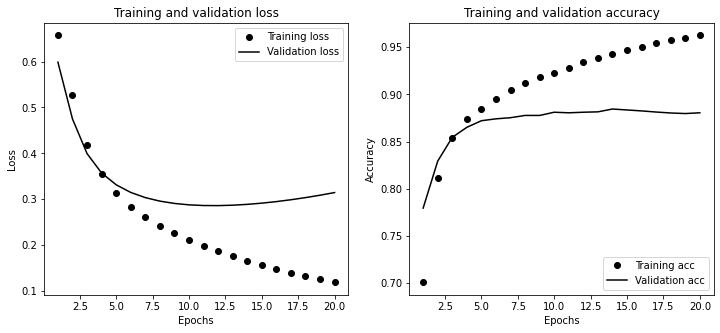

In [30]:
def plot_history(history_dict):
    acc = history_dict["binary_accuracy"]
    val_acc = history_dict["val_binary_accuracy"]
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]

    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, "ko", label="Training loss")
    plt.plot(epochs, val_loss, "k", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, "ko", label="Training acc")
    plt.plot(epochs, val_acc, "k", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right") 
    
    plt.show()
    
    
plot_history(history_dict_0)

## Modelo con regularización

In [31]:
model_1 = tf.keras.Sequential(
    [
        #
        # Dropout aleatoriamente fija las entradas en cero con
        # una frecuencia dada por rate, con el fin de prevenir
        # el sobre-entrenamiento. Las entradas que no son fijas
        # en 0 se multiplican por 1 / (1 - rate) para que la 
        # suma sobre todas las entradas permanezca igual
        #
        layers.Embedding(MAX_FEATURES + 1, EMBEDDING_DIM),        
        layers.Dropout(rate=0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(rate=0.2),
        layers.Dense(1),
    ]
)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Ejemplo Dropout

In [32]:
import numpy as np

#
# Semilla del generador de aleatorios
#
tf.random.set_seed(0)

#
# Crea una capa con dropout y salida g(x) = x
#
layer = tf.keras.layers.Dropout(.2, input_shape=(2,))

#
# Datos de entrada
#
data = np.arange(10).reshape(5, 2).astype(np.float32)
data

array([[0., 1.],
       [2., 3.],
       [4., 5.],
       [6., 7.],
       [8., 9.]], dtype=float32)

In [33]:
#
# Salida de la capa sin dropout
#
layer(data, training=False)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.],
       [6., 7.],
       [8., 9.]], dtype=float32)>

In [34]:
#
# Salida de la capa con dropout.
# Los pesos son multiplicados por
#
# 1 / (1 - rate) = 1 / 0.8 = 1.25
#
layer(data, training=True)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.  ,  1.25],
       [ 2.5 ,  3.75],
       [ 5.  ,  6.25],
       [ 7.5 ,  8.75],
       [10.  ,  0.  ]], dtype=float32)>

In [35]:
#
# Una nueva llamada cambia las entradas
# llevadas a cero
#
layer(data, training=True)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.  ,  1.25],
       [ 2.5 ,  3.75],
       [ 5.  ,  6.25],
       [ 0.  ,  8.75],
       [10.  , 11.25]], dtype=float32)>

## Compilación del modelo

In [36]:
model_1.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0),
)

In [37]:
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
)

Epoch 1/20
625/625 [==============================] - 3s 4ms/step - loss: 0.6824 - binary_accuracy: 0.6090 - val_loss: 0.6156 - val_binary_accuracy: 0.7720
Epoch 2/20
625/625 [==============================] - 3s 4ms/step - loss: 0.5803 - binary_accuracy: 0.7827 - val_loss: 0.4989 - val_binary_accuracy: 0.8222
Epoch 3/20
625/625 [==============================] - 3s 4ms/step - loss: 0.4665 - binary_accuracy: 0.8349 - val_loss: 0.4203 - val_binary_accuracy: 0.8476
Epoch 4/20
625/625 [==============================] - 3s 4ms/step - loss: 0.3920 - binary_accuracy: 0.8582 - val_loss: 0.3737 - val_binary_accuracy: 0.8610
Epoch 5/20
625/625 [==============================] - 3s 4ms/step - loss: 0.3443 - binary_accuracy: 0.8757 - val_loss: 0.3448 - val_binary_accuracy: 0.8686
Epoch 6/20
625/625 [==============================] - 3s 4ms/step - loss: 0.3107 - binary_accuracy: 0.8876 - val_loss: 0.3259 - val_binary_accuracy: 0.8718
Epoch 7/20
625/625 [==============================] - 3s 4ms/ste

In [38]:
# loss, accuracy
model_1.evaluate(train_ds)

625/625 [==============================] - 1s 1ms/step - loss: 0.1292 - binary_accuracy: 0.9584


[0.1292424201965332, 0.9584000110626221]

In [39]:
# loss, accuracy
model_1.evaluate(test_ds)

782/782 [==============================] - 1s 1ms/step - loss: 0.3335 - binary_accuracy: 0.8683


[0.33350175619125366, 0.8682799935340881]

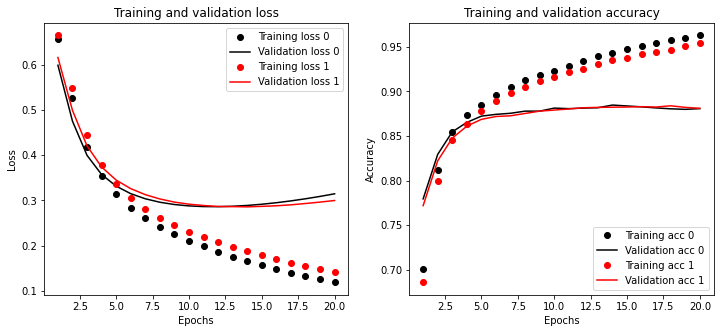

In [40]:
def plot_history(history_dict_0, history_dict_1):

    acc_0 = history_dict_0["binary_accuracy"]
    val_acc_0 = history_dict_0["val_binary_accuracy"]
    loss_0 = history_dict_0["loss"]
    val_loss_0 = history_dict_0["val_loss"]

    acc_1 = history_dict_1["binary_accuracy"]
    val_acc_1 = history_dict_1["val_binary_accuracy"]
    loss_1 = history_dict_1["loss"]
    val_loss_1 = history_dict_1["val_loss"]

    epochs = range(1, len(acc_0) + 1)
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_0, "ko", label="Training loss 0")
    plt.plot(epochs, val_loss_0, "k", label="Validation loss 0")
    plt.plot(epochs, loss_1, "ro", label="Training loss 1")
    plt.plot(epochs, val_loss_1, "r", label="Validation loss 1")    
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_0, "ko", label="Training acc 0")
    plt.plot(epochs, val_acc_0, "k", label="Validation acc 0")
    plt.plot(epochs, acc_1, "ro", label="Training acc 1")
    plt.plot(epochs, val_acc_1, "r", label="Validation acc 1")    
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right") 
    
    plt.show()
    
    
plot_history(history_0.history, history_1.history)

## Modelo en productivo

In [41]:
#
# Es posibles crear un modleo que combine los
# pasos anteriores.
#
export_model = tf.keras.Sequential(
    [
                vectorize_layer,
                model_0,
        layers.Activation("sigmoid"),
    ]
)

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

# 
# Se ejecuta el modelo empaquetado sobre los 
# datos de prueba originales (sin preprocesar).
# La funcion evaluate retorna la perdida y 
# precision
#
export_model.evaluate(raw_test_ds)

782/782 [==============================] - 21s 26ms/step - loss: 0.3491 - accuracy: 0.8648


[0.35619601607322693, 0.8643199801445007]

In [42]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
]

export_model.predict(examples)

array([[0.687941  ],
       [0.41689426],
       [0.3150716 ]], dtype=float32)